In [2]:
import os
from math import log, ceil
from typing import List, Tuple, Set, Dict
import pickle
from pathlib import Path

import numpy as np
from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, random_split


In [3]:
dirname = Path().resolve()
infname = dirname.parent / 'data/input/skill_builder_data_corrected.pickle'

with open(infname, 'rb') as f:
    data = pickle.load(f)

# Embedding
https://pytorch.org/docs/stable/nn.html#embedding

In [46]:
M = 26688+1
N = ceil(log(2 * M))

In [47]:
input = torch.LongTensor([145])
embedding = nn.Embedding(M, N)
e = embedding(input)

In [48]:
e

tensor([[-0.5166, -0.9605,  0.2136, -0.1716,  1.2936, -0.8574,  0.4236, -0.9219,
          0.3301,  0.3970, -0.3356]], grad_fn=<EmbeddingBackward>)

# RNN
https://pytorch.org/docs/stable/nn.html#rnn

In [71]:
rnn = nn.RNN(10, 20, 100)
input = torch.randn(10, 1, 10)
h0 = torch.randn(100, 1, 20)
output, hn = rnn(input, h0)

In [72]:
output.size()

torch.Size([10, 1, 20])

In [77]:
output.size(0)

10

In [78]:
output.size(1)

1

In [79]:
output.size(2)

20

In [81]:
output.contiguous().view(10, 20)

tensor([[ 6.3679e-01,  9.2506e-01, -4.3670e-01, -4.8357e-01, -3.7038e-01,
          2.3508e-01, -5.4885e-02, -8.1267e-03,  3.9844e-01,  3.4068e-01,
         -8.7025e-02,  1.0716e-01, -4.5075e-01, -6.9968e-01, -5.0000e-01,
         -3.3292e-01,  8.4960e-01,  2.9144e-02, -8.1647e-01,  6.1188e-01],
        [-4.0968e-02, -4.6676e-01, -5.4840e-01, -6.3862e-01, -9.8110e-02,
         -3.2573e-01, -5.5970e-01,  2.2142e-01, -5.2223e-01, -3.4984e-01,
          2.1804e-01,  1.7349e-01, -5.3331e-01, -3.8534e-01,  1.3440e-01,
         -5.1388e-01, -1.7391e-01,  1.9375e-01, -4.0908e-01,  1.4386e-01],
        [-1.3205e-01, -2.3401e-01, -2.3190e-01, -5.1171e-01, -8.6793e-02,
         -4.0042e-01, -1.0590e-01, -7.9196e-02, -5.3169e-02, -4.2956e-01,
          2.4921e-01,  1.8581e-01, -5.3975e-01, -1.3230e-01, -1.8388e-01,
         -3.3575e-01,  5.9694e-01,  2.5942e-01, -2.4107e-01,  6.6964e-01],
        [-2.5452e-01, -1.8232e-01, -3.4223e-01, -5.3058e-01,  1.4869e-01,
         -3.4410e-01, -3.0910e-01, 

In [84]:
decoder = nn.Linear(20, 10)
decoder(output.contiguous().view(10, 20))

tensor([[-0.3105,  0.1158,  0.0044, -0.4615,  0.1008, -0.2421,  0.0286,  0.7411,
          0.0107, -0.1633],
        [-0.1512,  0.1831,  0.2385, -0.3984,  0.1127,  0.0525,  0.1571,  0.2903,
         -0.0915,  0.1583],
        [-0.0670,  0.3136,  0.1289, -0.3910,  0.1442, -0.0404,  0.1840,  0.4297,
          0.0207, -0.0770],
        [-0.1334,  0.2560,  0.2183, -0.3924,  0.0808, -0.2097,  0.3281,  0.3611,
         -0.0299,  0.0423],
        [-0.0652,  0.2462,  0.1277, -0.3984,  0.0766, -0.0683,  0.2620,  0.3248,
         -0.0660,  0.0603],
        [-0.0482,  0.2495,  0.1304, -0.4210,  0.0695, -0.1330,  0.2947,  0.2934,
         -0.0532,  0.0627],
        [-0.0374,  0.2259,  0.1287, -0.4006,  0.0496, -0.1378,  0.2723,  0.2919,
         -0.0412,  0.0624],
        [-0.0409,  0.2273,  0.1239, -0.4033,  0.0518, -0.1155,  0.2629,  0.2886,
         -0.0418,  0.0583],
        [-0.0413,  0.2209,  0.1179, -0.4024,  0.0608, -0.1161,  0.2684,  0.2846,
         -0.0406,  0.0620],
        [-0.0384,  

In [206]:
class DKT(nn.Module):
    def __init__(self, n_input, n_hidden, n_skills, n_layers, dropout=0.6):
        super(DKT, self).__init__()
        nonlinearity = 'tanh'
        self.rnn = nn.RNN(n_input, n_hidden, n_layers, nonlinearity=nonlinearity, dropout=dropout)
        self.decoder = nn.Linear(n_hidden, n_skills)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input, h0):
        out, hn = self.rnn(input, h0)
        decoded = self.decoder(out.contiguous().view(out.size(0) * out.size(1), out.size(2)))
        decoded = self.sigmoid(decoded)
        return decoded, hn
    

In [163]:
batch_size, n_input, n_hidden, n_skills, n_layers = 100, 11, 200, 124, 3
model = DKT(n_input, n_hidden, n_skills, n_layers)

criterion = nn.BCELoss()
opt = optim.SGD(model.parameters(), lr=0.01)

In [171]:
# 2は可変長かな
input = torch.randn(batch_size, 2, n_input)
h0 = torch.randn(n_layers, 2, n_hidden)
o, hn = model(input, h0)
o.size(), hn.size(), o, hn

(torch.Size([200, 124]),
 torch.Size([3, 2, 200]),
 tensor([[0.6116, 0.4820, 0.5035,  ..., 0.6342, 0.5009, 0.4757],
         [0.4488, 0.6189, 0.5894,  ..., 0.4676, 0.4545, 0.3915],
         [0.5188, 0.5279, 0.4348,  ..., 0.5622, 0.5932, 0.5538],
         ...,
         [0.5104, 0.4528, 0.5390,  ..., 0.5472, 0.5325, 0.4887],
         [0.5083, 0.4951, 0.5387,  ..., 0.4979, 0.5320, 0.5474],
         [0.5366, 0.4896, 0.4657,  ..., 0.5006, 0.5350, 0.4768]],
        grad_fn=<SigmoidBackward>),
 tensor([[[ 0.2260,  0.0347,  0.1071,  ...,  0.0734,  0.0432,  0.0282],
          [ 0.2131, -0.0432,  0.1415,  ...,  0.1503, -0.0308, -0.1016]],
 
         [[ 0.1415, -0.2512, -0.1896,  ..., -0.1539,  0.0097, -0.0489],
          [ 0.3127,  0.3186, -0.1157,  ..., -0.2915,  0.0513,  0.0634]],
 
         [[ 0.2399, -0.2789, -0.4127,  ..., -0.0190,  0.0545,  0.2523],
          [ 0.2764,  0.2872, -0.0723,  ..., -0.0987, -0.1603,  0.1673]]],
        grad_fn=<StackBackward>))

In [122]:
for epoch in range(2):
    input = torch.randn(2000, 1, 10)
    h0 = Variable(torch.zeros(2, 1, n_hidden))
    target = torch.Tensor([np.eye(124)[64] for _ in range(2000)])
    
    out, hn = model(input, h0)
    
    loss = criterion(out, target)
    
    opt.zero_grad()
    loss.backward()
    opt.step()

# 作っていくよー！

In [147]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sys

sys.path.append('..')
from src.data import prepare_data

import seaborn as sns
import matplotlib.pyplot as plt

In [177]:
data = prepare_data()
M = 124

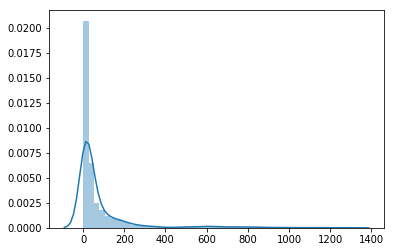

In [148]:
sns.distplot([len(d) for d in data.values()])

In [509]:
min_n, max_n = 3, 30
sequence_size = 30

N = ceil(log(2 * M))

def qaToIdxNum(q_and_a: Tuple) -> int:
    return q_and_a[0] + q_and_a[1] * M + 1  # consider 0

def idxToOneHot(idxnum: int):  # idxnum should already considered 0
    onehot = np.zeros(2*M + 1)  # consider 0
    onehot[idxnum] = 1
    return onehot

def qaToOnehot(q_and_a: Tuple):
    idx = qaToIdxNum(q_and_a)
    onehot = idxToOneHot(idx)
    return onehot

def sequenceToOnehot(sequence_qa: List):
    length = len(sequence_qa)
    sequence = list(map(qaToIdxNum, sequence_qa)) + [0] * (sequence_size - length)
    onehotSeq = list(map(idxToOneHot, sequence))
    return onehotSeq

def qaToOnehotQandA(qa: Tuple):
    onehot_q = np.zeros(M)
    onehot_q[qa[0]] = 1
    a = qa[1]
    return onehot_q, a


x_values = []
y_values = []
x_onehot = []
y_onehot = []
y_onehot_q = []
y_onehot_a = []
for d in data.values():
    if max_n < len(d): # max_n + 1 以上の長さから、最後をy、それまでで最後のmax_nをxとする
        x_values.append(d[-1-max_n:-1])
        y_values.append(d[-1])
        x_onehot.append(sequenceToOnehot(d[-1-max_n:-1]))
        y_onehot.append(qaToOnehot(d[-1]))
        ohq, a = qaToOnehotQandA(d[-1])
        y_onehot_q.append(ohq)
        y_onehot_a.append(a)
    elif min_n <= len(d) <= max_n:
        x_values.append(d[:-1])
        y_values.append(d[-1])
        x_onehot.append(sequenceToOnehot(d[-1-max_n:-1]))
        y_onehot.append(qaToOnehot(d[-1]))
        ohq, a = qaToOnehotQandA(d[-1])
        y_onehot_q.append(ohq)
        y_onehot_a.append(a)
    else:
        pass

x_tensor, y_tensor = torch.Tensor(x_onehot), torch.Tensor(y_onehot)
print(x_tensor.size(), y_tensor.size())
y_tensor_q, y_tensor_a = torch.Tensor(y_onehot_q), torch.Tensor(y_onehot_a)
print(y_tensor_q.size(), y_tensor_a.size())
all_ds = TensorDataset(x_tensor, y_tensor_q, y_tensor_a)

train_num = int(len(all_ds) * .8)
train_ds, eval_ds = random_split(all_ds, [train_num, len(all_ds) - train_num])
print(len(train_ds), len(eval_ds))

torch.Size([3884, 30, 249]) torch.Size([3884, 249])
torch.Size([3884, 124]) torch.Size([3884])
3107 777


In [466]:
tmp = torch.Tensor(
[
    [[0,0,1], [0,2,0]],
    [[0,0,3], [0,4,0]],
    [[0,0,5], [0,6,0]],
    [[0,0,7], [0,8,0]]
]
)
print(tmp.size())
tmp.permute(1, 0, 2)

torch.Size([4, 2, 3])


tensor([[[0., 0., 1.],
         [0., 0., 3.],
         [0., 0., 5.],
         [0., 0., 7.]],

        [[0., 2., 0.],
         [0., 4., 0.],
         [0., 6., 0.],
         [0., 8., 0.]]])

In [540]:
class DKT(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, n_layers, dropout=0.6):
        super(DKT, self).__init__()
        nonlinearity = 'tanh'
        # https://pytorch.org/docs/stable/nn.html#rnn
        self.rnn = nn.RNN(n_input, n_hidden, n_layers, nonlinearity=nonlinearity, dropout=dropout)
        self.decoder = nn.Linear(n_hidden, n_output)
        # self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, input, h0):
        out, hn = self.rnn(input, h0)
        # top_n, top_i = out.topk(1)
        # decoded = self.decoder(out.contiguous().view(out.size(0) * out.size(1), out.size(2)))
        out = self.decoder(out)
        # decoded = self.sigmoid(decoded)
    
        return out, hn
    

batch_size, n_input, n_hidden, n_skills, n_layers = 100, N, 200, 124, 1
n_output = n_skills
onehot_size = n_skills * 2 + 1
# n_input = onehot_size  #
all_dl = DataLoader(all_ds, batch_size=batch_size, drop_last=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, drop_last=True)
eval_dl = DataLoader(eval_ds, batch_size=batch_size, drop_last=True)

model = DKT(n_input, n_hidden, n_output, n_layers)
# model  = nn.RNN(n_input, n_hidden, n_layers, nonlinearity='tanh', dropout=0.6)

criterion = nn.BCELoss()
opt = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(1, 501):  # epochは全体を回す処理
    model.train()
    for xs, yq, ya in train_dl:
        input = xs
        compressed_sensing = True
        if compressed_sensing and onehot_size != n_input:
            torch.manual_seed(0)
            cs_basis = torch.randn(onehot_size, n_input)
            input = torch.mm(input.contiguous().view(-1, onehot_size), cs_basis)
            # https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn
            # inputの説明を見ると、input of shape (seq_len, batch, input_size)　とある
            input = input.view(batch_size, sequence_size, n_input)
        input = input.permute(1, 0, 2)

        h0 = torch.zeros(n_layers, batch_size, n_hidden)
        target = ya

        out, hn = model(input, h0)

        # logits = torch.gather(output, 0, target_id)

        pred = torch.sigmoid(out[-1])  # [0, 1]区間にする
        prob = torch.max(pred * yq, 1)[0]
        loss = criterion(prob, target)  # TODO: 最後の1個だけじゃなくて、その他も損失関数に利用したら？
        if epoch % 100 == 0:
            print(loss)
    
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        break
    
    if epoch % 500 == 0:
        with torch.no_grad():
            model.eval()
            
            val_prob = []
            val_targ = []
            for xs, yq, ya in eval_dl:
                input = xs
                if compressed_sensing:
                    torch.manual_seed(0)
                    cs_basis = torch.randn(onehot_size, n_input)
                    input = torch.mm(input.contiguous().view(-1, onehot_size), cs_basis)
                    # https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn
                    # inputの説明を見ると、input of shape (seq_len, batch, input_size)　とある
                    input = input.view(batch_size, sequence_size, n_input)
                input = input.permute(1, 0, 2)
                target = ya
                h0 = torch.zeros(n_layers, batch_size, n_hidden)
                out, hn = model(input, h0)
                pred = torch.sigmoid(out[-1])  # [0, 1]区間にする
                prob = torch.max(pred * yq, 1)[0]
                loss = criterion(prob, target)
                
                val_prob.append(prob)
                val_targ.append(target)
                
            y = torch.cat(val_targ)
            pred = torch.cat(val_prob)
            fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
            print(metrics.auc(fpr, tpr))

/Users/qiushi/packages/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


tensor(0.6640, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6050, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5661, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5211, grad_fn=<BinaryCrossEntropyBackward>)
0.5857543578441194


In [1]:
loss

NameError: name 'loss' is not defined

In [445]:
torch.sigmoid(out[0][-1][80])

tensor(0.4689)

In [449]:
ys[-1].max(0)

(tensor(1.), tensor(80))

In [372]:
random_matrix = torch.randn(n_skills * 2, n_input)
input = torch.mm(torch.Tensor(x_onehot[0:1]).contiguous().view(-1, 248), random_matrix)
print(torch.Tensor(x_onehot[0:1]).size())
input = input.view(30, 1, 6)
h0 = torch.zeros(n_layers, 1, n_hidden)

model = nn.RNN(n_input, n_hidden, n_layers, nonlinearity='tanh', dropout=0.6)
model(input, h0)

torch.Size([1, 30, 248])


(tensor([[[-0.1278,  0.0492,  0.0696,  ..., -0.0495,  0.1539, -0.1486]],
 
         [[-0.0380, -0.0167, -0.0010,  ..., -0.1320,  0.1119, -0.2290]],
 
         [[ 0.1597, -0.1223, -0.2632,  ..., -0.0651,  0.1030, -0.2331]],
 
         ...,
 
         [[ 0.2434,  0.0246, -0.0651,  ..., -0.0814,  0.0284,  0.0096]],
 
         [[ 0.2554,  0.0215, -0.1880,  ..., -0.0730,  0.1586, -0.1213]],
 
         [[ 0.2074,  0.0412, -0.1263,  ...,  0.0578,  0.2029, -0.2085]]],
        grad_fn=<StackBackward>),
 tensor([[[ 2.0741e-01,  4.1194e-02, -1.2627e-01,  9.5058e-02,  5.9134e-02,
            1.6616e-04,  1.1978e-01,  6.9009e-02,  1.3488e-01, -1.3914e-01,
           -4.0156e-02,  1.5901e-01,  3.0396e-02,  1.2145e-01,  5.9034e-02,
            7.5554e-02, -8.9835e-02,  2.1130e-01,  2.6609e-02, -3.4190e-02,
            1.1141e-01, -1.1124e-01, -2.5882e-02,  3.1236e-02, -1.1198e-02,
            2.6103e-01, -9.9711e-02,  8.6882e-02, -1.6155e-01,  2.2450e-02,
            1.1042e-01,  7.8981e-02,  1.1196e

In [342]:
torch.LongTensor(x_onehot[0:2]).contiguous().view(-1, 248)

torch.Size([60, 248])

# 調整してくよー！

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, random_split

import os
from math import log, ceil
from typing import List, Tuple, Set, Dict
import pickle
from pathlib import Path

import numpy as np
from sklearn import metrics

from src.data import prepare_data


# =========================
# PyTorch version
# =========================
print('PyTorch:', torch.__version__)


# =========================
# Parameters
# =========================
lr = 0.01
batch_size, n_hidden, n_skills, n_layers = 100, 200, 124, 1
n_output = n_skills
onehot_size = n_skills * 2 + 1
n_input = ceil(log(2 * n_skills))
# n_input = onehot_size  #

# =========================
# Data
# =========================
data = prepare_data()
M = n_skills
min_n, max_n = 3, 30
sequence_size = 30

N = ceil(log(2 * M))


def qaToIdxNum(q_and_a: Tuple) -> int:
    return q_and_a[0] + q_and_a[1] * M + 1  # consider 0


def idxToOneHot(idxnum: int):  # idxnum should already considered 0
    onehot = np.zeros(2 * M + 1)  # consider 0
    onehot[idxnum] = 1
    return onehot


def qaToOnehot(q_and_a: Tuple):
    idx = qaToIdxNum(q_and_a)
    onehot = idxToOneHot(idx)
    return onehot


def sequenceToOnehot(sequence_qa: List):
    length = len(sequence_qa)
    sequence = list(map(qaToIdxNum, sequence_qa)) + \
        [0] * (sequence_size - length)
    onehotSeq = list(map(idxToOneHot, sequence))
    return onehotSeq


def qaToOnehotQandA(qa: Tuple):
    onehot_q = np.zeros(M)
    onehot_q[qa[0]] = 1
    a = qa[1]
    return onehot_q, a


x_values = []
y_values = []
x_onehot = []
y_onehot = []
y_onehot_q = []
y_onehot_a = []
for d in data.values():
    if max_n < len(d):  # max_n + 1 以上の長さから、最後をy、それまでで最後のmax_nをxとする
        x_values.append(d[-1 - max_n:-1])
        y_values.append(d[-1])
        x_onehot.append(sequenceToOnehot(d[-1 - max_n:-1]))
        y_onehot.append(qaToOnehot(d[-1]))
        ohq, a = qaToOnehotQandA(d[-1])
        y_onehot_q.append(ohq)
        y_onehot_a.append(a)
    elif min_n <= len(d) <= max_n:
        x_values.append(d[:-1])
        y_values.append(d[-1])
        x_onehot.append(sequenceToOnehot(d[-1 - max_n:-1]))
        y_onehot.append(qaToOnehot(d[-1]))
        ohq, a = qaToOnehotQandA(d[-1])
        y_onehot_q.append(ohq)
        y_onehot_a.append(a)
    else:
        pass

x_tensor, y_tensor = torch.Tensor(x_onehot), torch.Tensor(y_onehot)
y_tensor_q, y_tensor_a = torch.Tensor(y_onehot_q), torch.Tensor(y_onehot_a)
all_ds = TensorDataset(x_tensor, y_tensor_q, y_tensor_a)
train_num = int(len(all_ds) * .8)
train_ds, eval_ds = random_split(all_ds, [train_num, len(all_ds) - train_num])

all_dl = DataLoader(all_ds, batch_size=batch_size, drop_last=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, drop_last=True)
eval_dl = DataLoader(eval_ds, batch_size=batch_size, drop_last=True)

# =========================
# Model
# =========================


class DKT(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, n_layers, dropout=0.6):
        super(DKT, self).__init__()
        nonlinearity = 'tanh'
        # https://pytorch.org/docs/stable/nn.html#rnn
        self.rnn = nn.RNN(n_input, n_hidden, n_layers,
                          nonlinearity=nonlinearity, dropout=dropout)
        self.decoder = nn.Linear(n_hidden, n_output)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, input, h0):
        out, hn = self.rnn(input, h0)
        # top_n, top_i = out.topk(1)
        # decoded = self.decoder(out.contiguous().view(out.size(0) * out.size(1), out.size(2)))
        out = self.decoder(out)
        # decoded = self.sigmoid(decoded)

        return out, hn


# =========================
# Prepare and Train
# =========================
loss_func = nn.BCELoss()
model = DKT(n_input, n_hidden, n_output, n_layers)
criterion = nn.BCELoss()
opt = optim.SGD(model.parameters(), lr=lr)


for epoch in range(1, 2001):  # epochは全体を回す処理
    model.train()
    for xs, yq, ya in train_dl:
        input = xs
        compressed_sensing = True
        if compressed_sensing and onehot_size != n_input:
            torch.manual_seed(0)
            cs_basis = torch.randn(onehot_size, n_input)
            input = torch.mm(
                input.contiguous().view(-1, onehot_size), cs_basis)
            # https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn
            # inputの説明を見ると、input of shape (seq_len, batch, input_size)　とある
            input = input.view(batch_size, sequence_size, n_input)
        input = input.permute(1, 0, 2)

        h0 = torch.zeros(n_layers, batch_size, n_hidden)
        target = ya

        out, hn = model(input, h0)

        # logits = torch.gather(output, 0, target_id)

        pred = torch.sigmoid(out[-1])  # [0, 1]区間にする
        prob = torch.max(pred * yq, 1)[0]
        loss = criterion(prob, target)  # TODO: 最後の1個だけじゃなくて、その他も損失関数に利用したら？
        if epoch % 100 == 0:
            print('Epoch:', epoch, 'Loss:', loss)

        opt.zero_grad()
        loss.backward()
        opt.step()

    if epoch % 100 == 0:
        with torch.no_grad():
            model.eval()
            for xs, yq, ya in eval_dl:
                input = xs
                if compressed_sensing:
                    torch.manual_seed(0)
                    cs_basis = torch.randn(onehot_size, n_input)
                    input = torch.mm(
                        input.contiguous().view(-1, onehot_size), cs_basis)
                    # https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn
                    # inputの説明を見ると、input of shape (seq_len, batch, input_size)　とある
                    input = input.view(batch_size, sequence_size, n_input)
                input = input.permute(1, 0, 2)
                target = ya
                h0 = torch.zeros(n_layers, batch_size, n_hidden)
                out, hn = model(input, h0)
                pred = torch.sigmoid(out[-1])  # [0, 1]区間にする
                prob = torch.max(pred * yq, 1)[0]
                loss = criterion(prob, target)
                print('EVAL Epoch:', epoch, 'Loss:', loss)

    if epoch % 500 == 0:
        with torch.no_grad():
            model.eval()

            val_prob = []
            val_targ = []
            for xs, yq, ya in eval_dl:
                input = xs
                if compressed_sensing:
                    torch.manual_seed(0)
                    cs_basis = torch.randn(onehot_size, n_input)
                    input = torch.mm(
                        input.contiguous().view(-1, onehot_size), cs_basis)
                    # https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn
                    # inputの説明を見ると、input of shape (seq_len, batch, input_size)　とある
                    input = input.view(batch_size, sequence_size, n_input)
                input = input.permute(1, 0, 2)
                target = ya
                h0 = torch.zeros(n_layers, batch_size, n_hidden)
                out, hn = model(input, h0)
                pred = torch.sigmoid(out[-1])  # [0, 1]区間にする
                prob = torch.max(pred * yq, 1)[0]
                loss = criterion(prob, target)

                val_prob.append(prob)
                val_targ.append(target)

            y = torch.cat(val_targ)
            pred = torch.cat(val_prob)
            fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
            print(metrics.auc(fpr, tpr))
